# Setting up a labeling task for Street2Sat
This notebook provides:
1. Generating list of random images to label [code]

## 1. Generating list of random images to label

In [ ]:
from datetime import datetime
from google.cloud import firestore
from google.cloud import storage
from tqdm.notebook import tqdm

import pandas as pd
import random

In [ ]:
# You may need to run the below commands to authenticate GCloud and set the correct project
# !gcloud auth login
# !gcloud config set project bsos-geog-harvest1

In [ ]:
# Initialize connections to cloud storage and database
client = storage.Client()
db = firestore.Client()
coll = db.collection("street2sat")

In [ ]:
# Get paths for images already in labelling tasks
images_already_being_labelled = []
csv_bucket = "street2sat-gcloud-labeling"
csv_names = [blob.name for blob in client.list_blobs(csv_bucket, prefix="") if blob.name.endswith(".csv")]

for csv_name in tqdm(csv_names):
    uris = pd.read_csv(f"gs://{csv_bucket}/{csv_name}", header=None, sep="\n")[0]
    images_already_being_labelled += uris.to_list()

In [ ]:
# Load in all available paths, this will take 3 minutes or so
all_paths = [blob.name for blob in tqdm(client.list_blobs('street2sat-uploaded', prefix=""))]  
random.shuffle(all_paths)

In [ ]:
def amount_of_objects_detected(uri: str):
    query = coll.where("input_img", "==", uri).limit(1).get()
    objects_detected = query[0].to_dict()["results"]
    return len(objects_detected)

def get_paths_with_predicted_objects(amount: int, object_threshold: int = 5):
    images_to_label = []
    for i, p in enumerate(all_paths):
        if len(images_to_label) >= amount:
            break
        uri = f"gs://street2sat-uploaded/{p}"
        if uri in images_already_being_labelled:
            continue
        if amount_of_objects_detected(uri) > object_threshold:
            images_to_label.append(uri)
    return images_to_label

In [ ]:
# Get random images to label with at least 5 objects predicted in each image
images_to_label = get_paths_with_predicted_objects(100, object_threshold=5)

In [ ]:
csv_name = datetime.now().strftime("%Y-%m-%d_%H-%-M-%S") + ".csv"
csv_name

In [ ]:
# Save image list to csv on Google Cloud Storage
df = pd.DataFrame(images_to_label)
df.to_csv(f"gs://{csv_bucket}/{csv_name}", sep="\n", index=False)

## 2. Creating a dataset on Vertex AI
a. Navigate to: https://console.cloud.google.com/vertex-ai/datasets?project=bsos-geog-harvest1 

b. Click **CREATE**

c. For Dataset name: use the `Y-%m-%d_%H-%-M-%S` format (same as for csv)

d. Select Image object detection radio button, your screen should look like this:

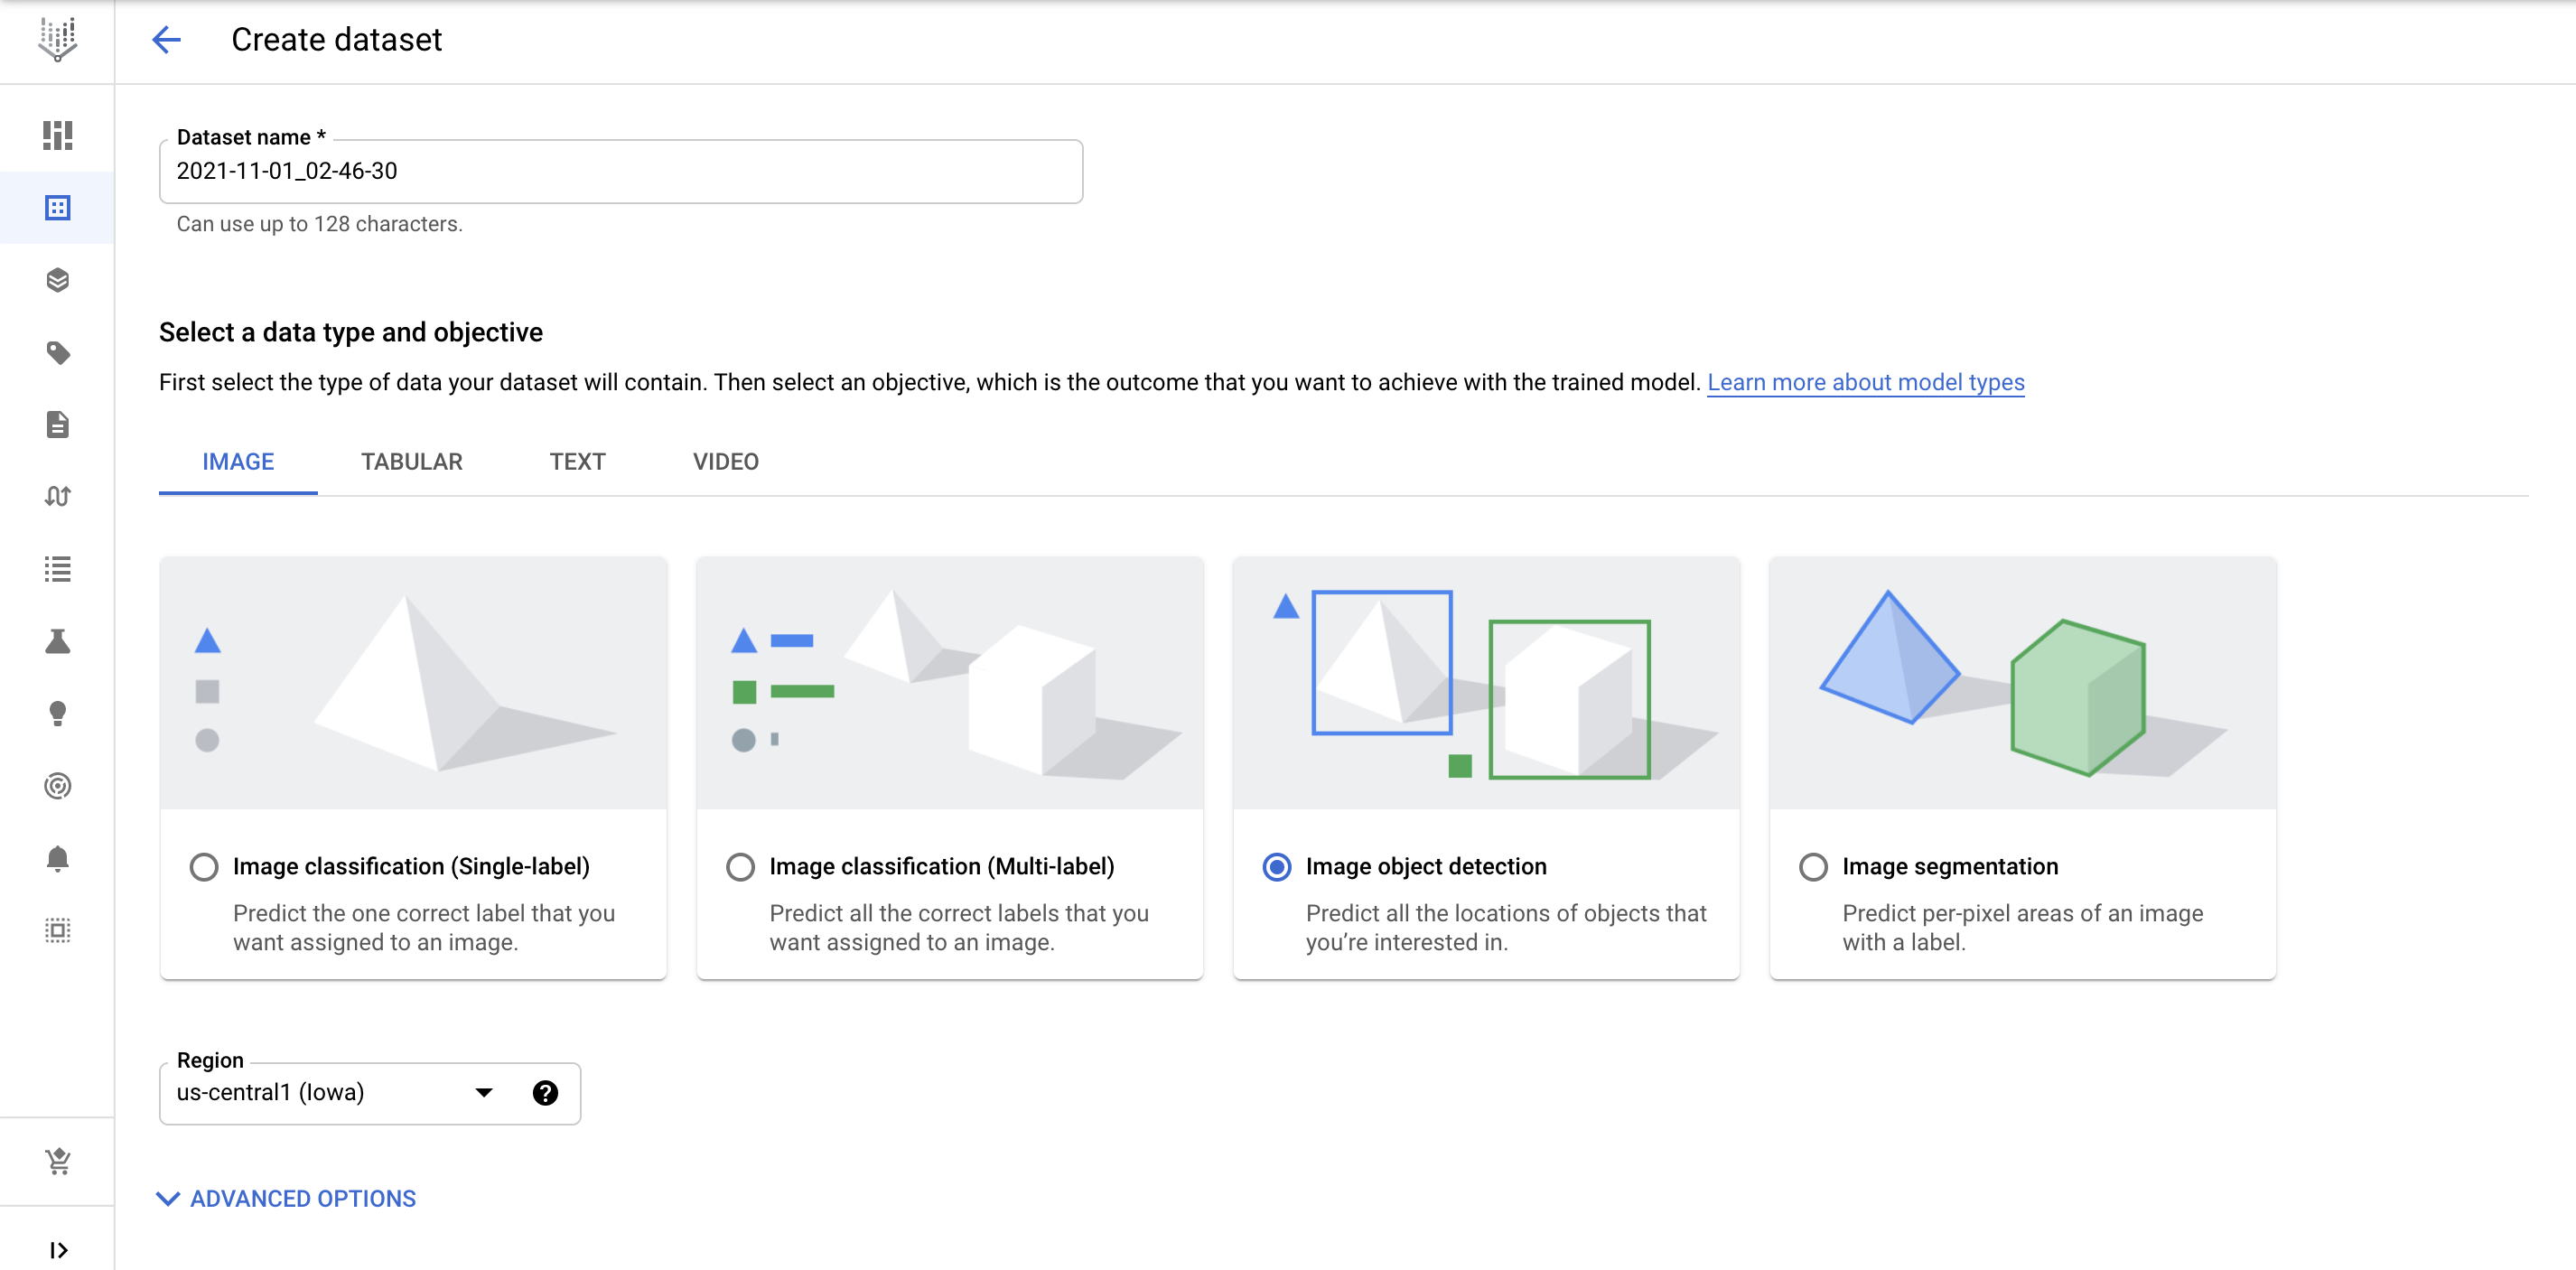

e. Click **CREATE** at the bottom.

f. Select the option to import files from Cloud Storage and locate the csv created above in the `street2sat-gcloud-labeling bucket`

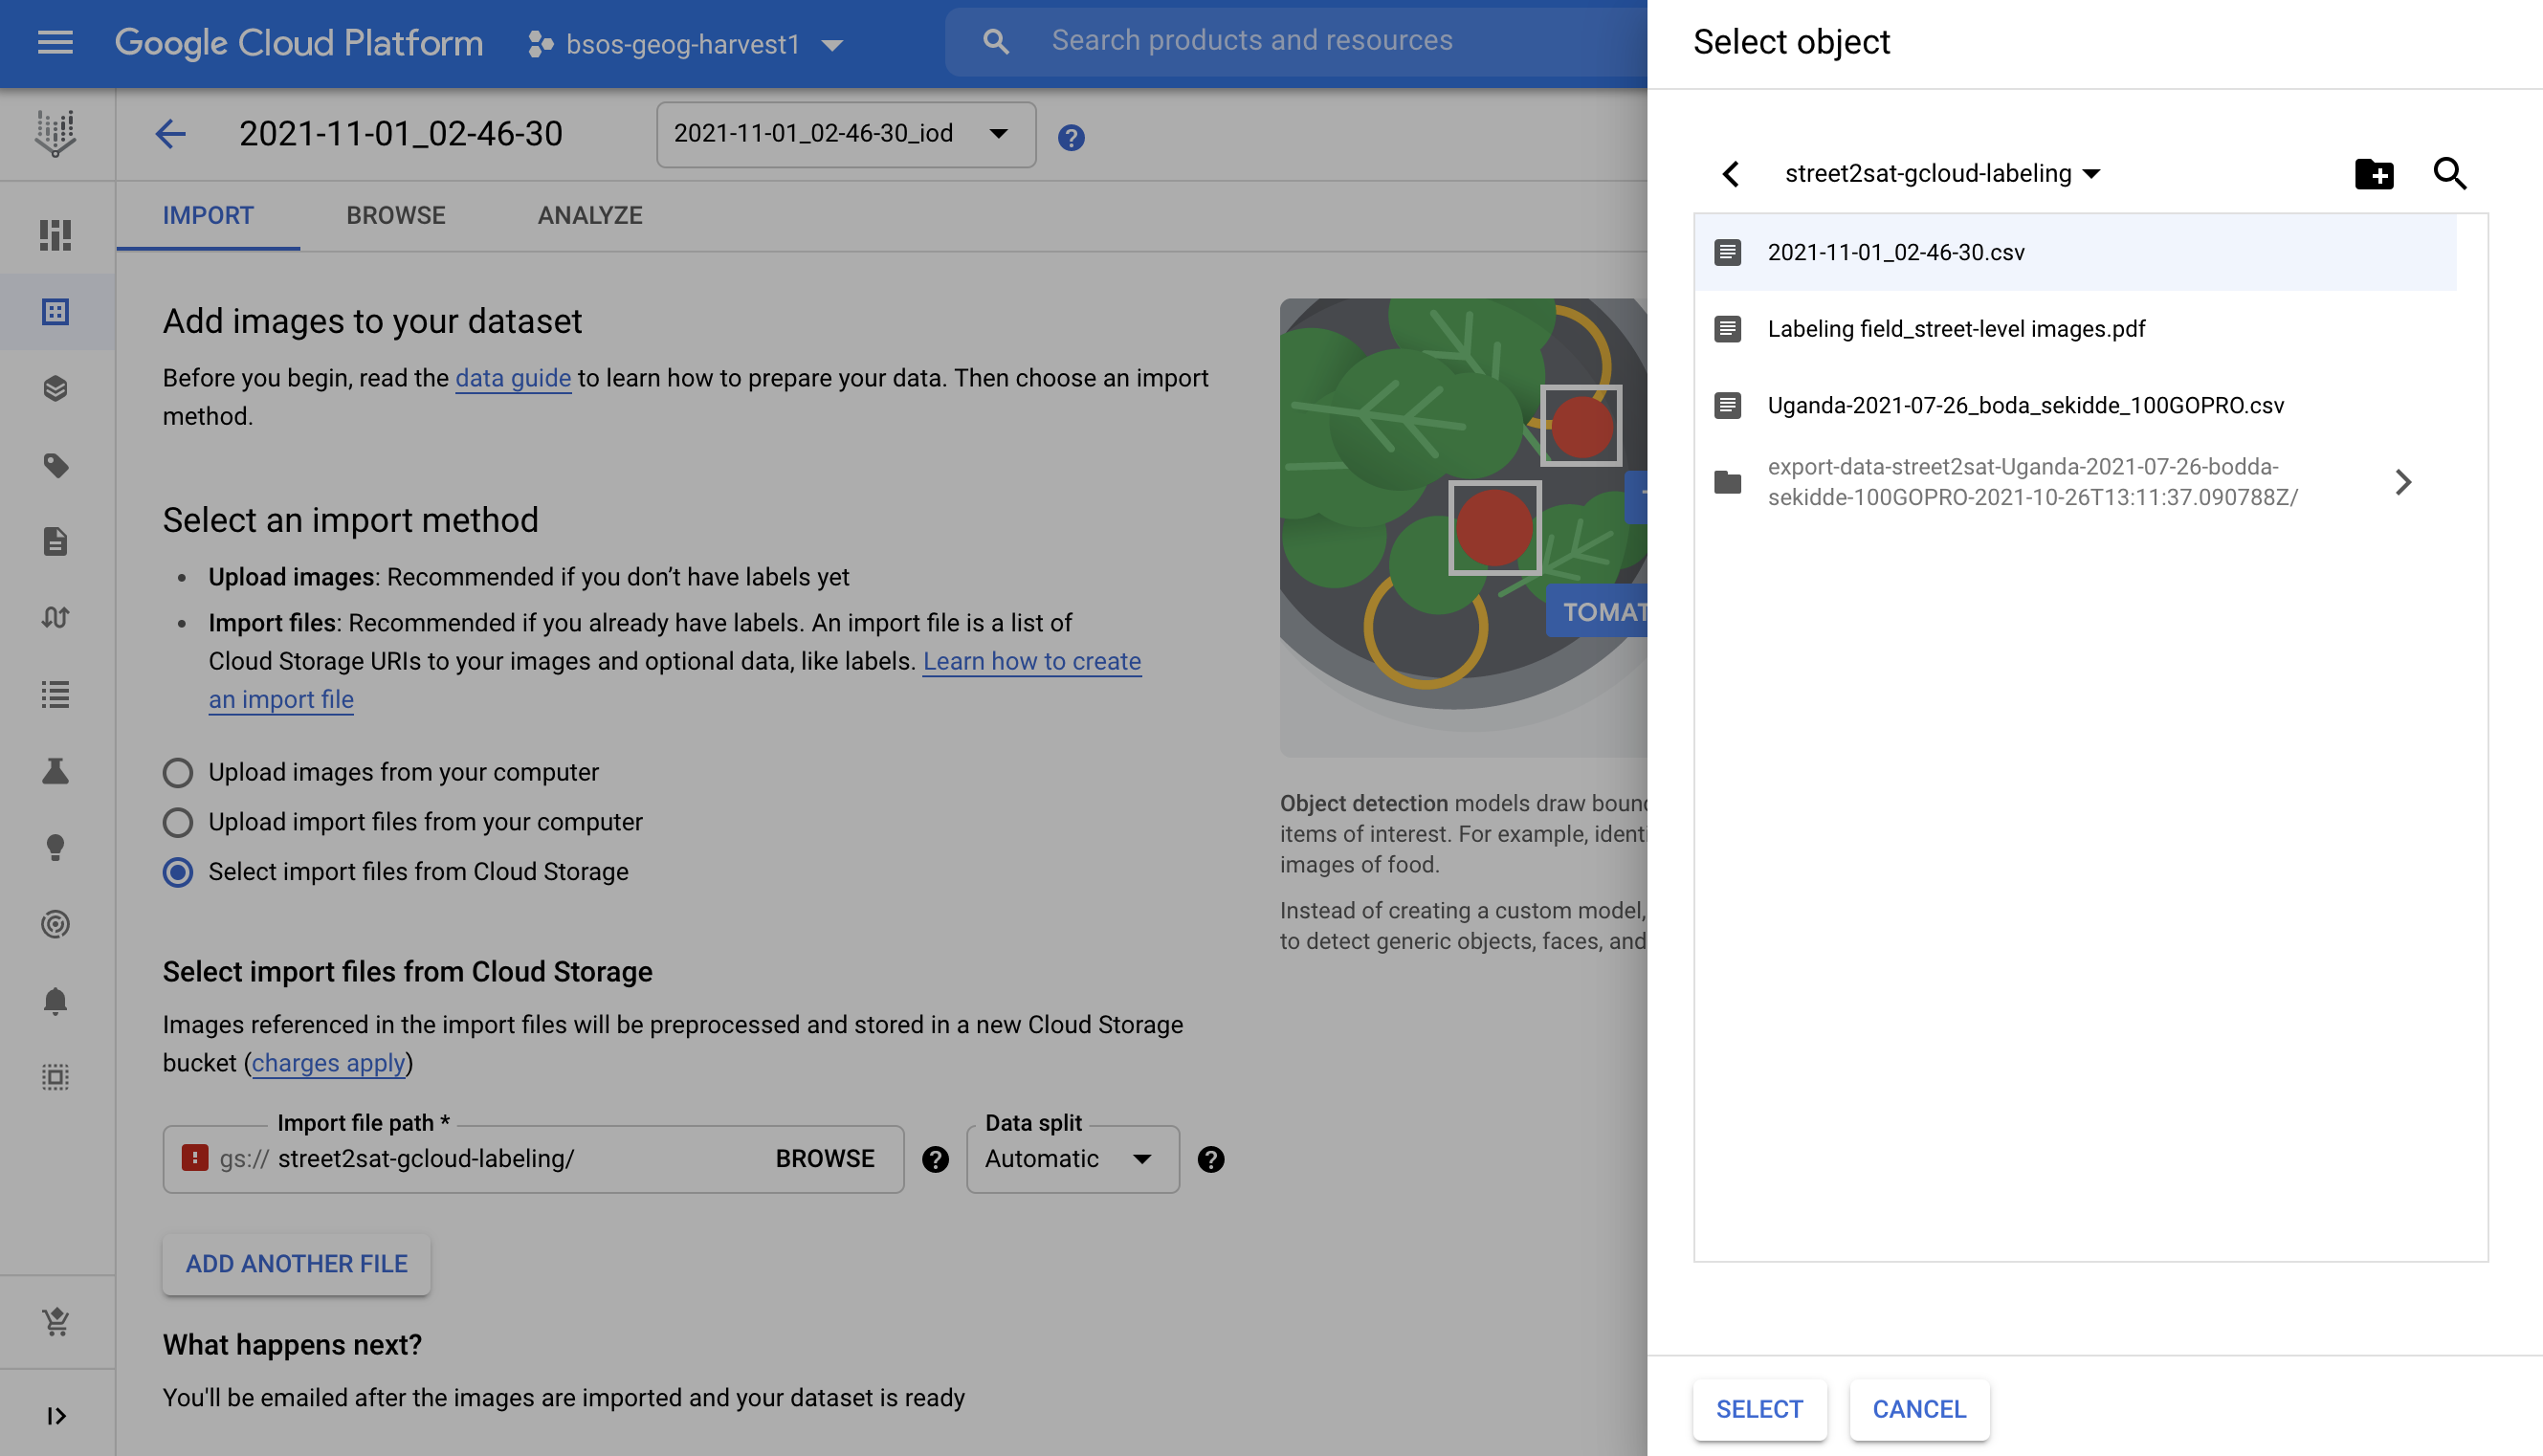

g. Click **Continue**

## 3. Creating a labeling task
You can create a labeling task during or after dataset creation is complete.

a. Click **CREATE LABELING TASK**

b. For Labeling Task name: use the `%Y-%m-%d_%H-%-M-%S` format with a task suffix

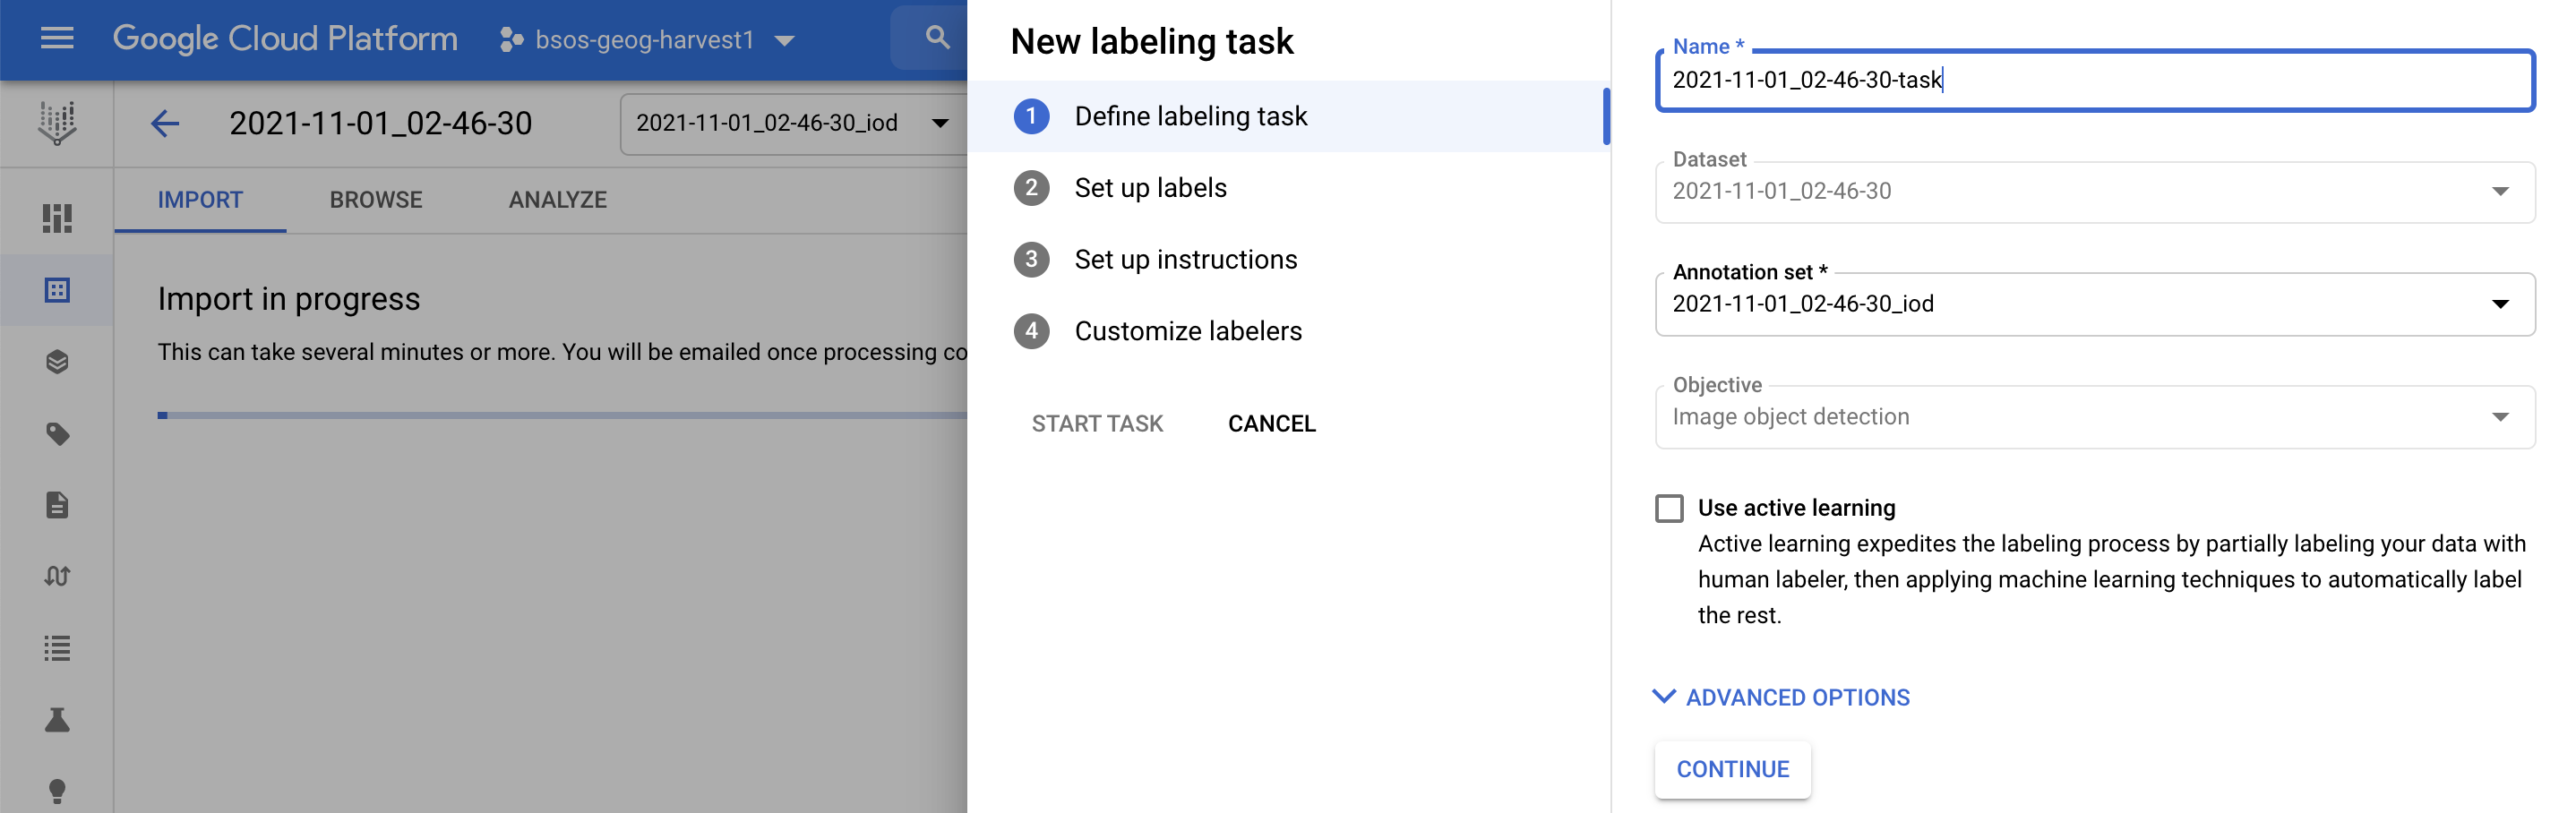

c. In step 2: input the labels as per [classes.txt](https://github.com/nasaharvest/street2sat_website/blob/main/street2sat_utils/crop_info/classes.txt)

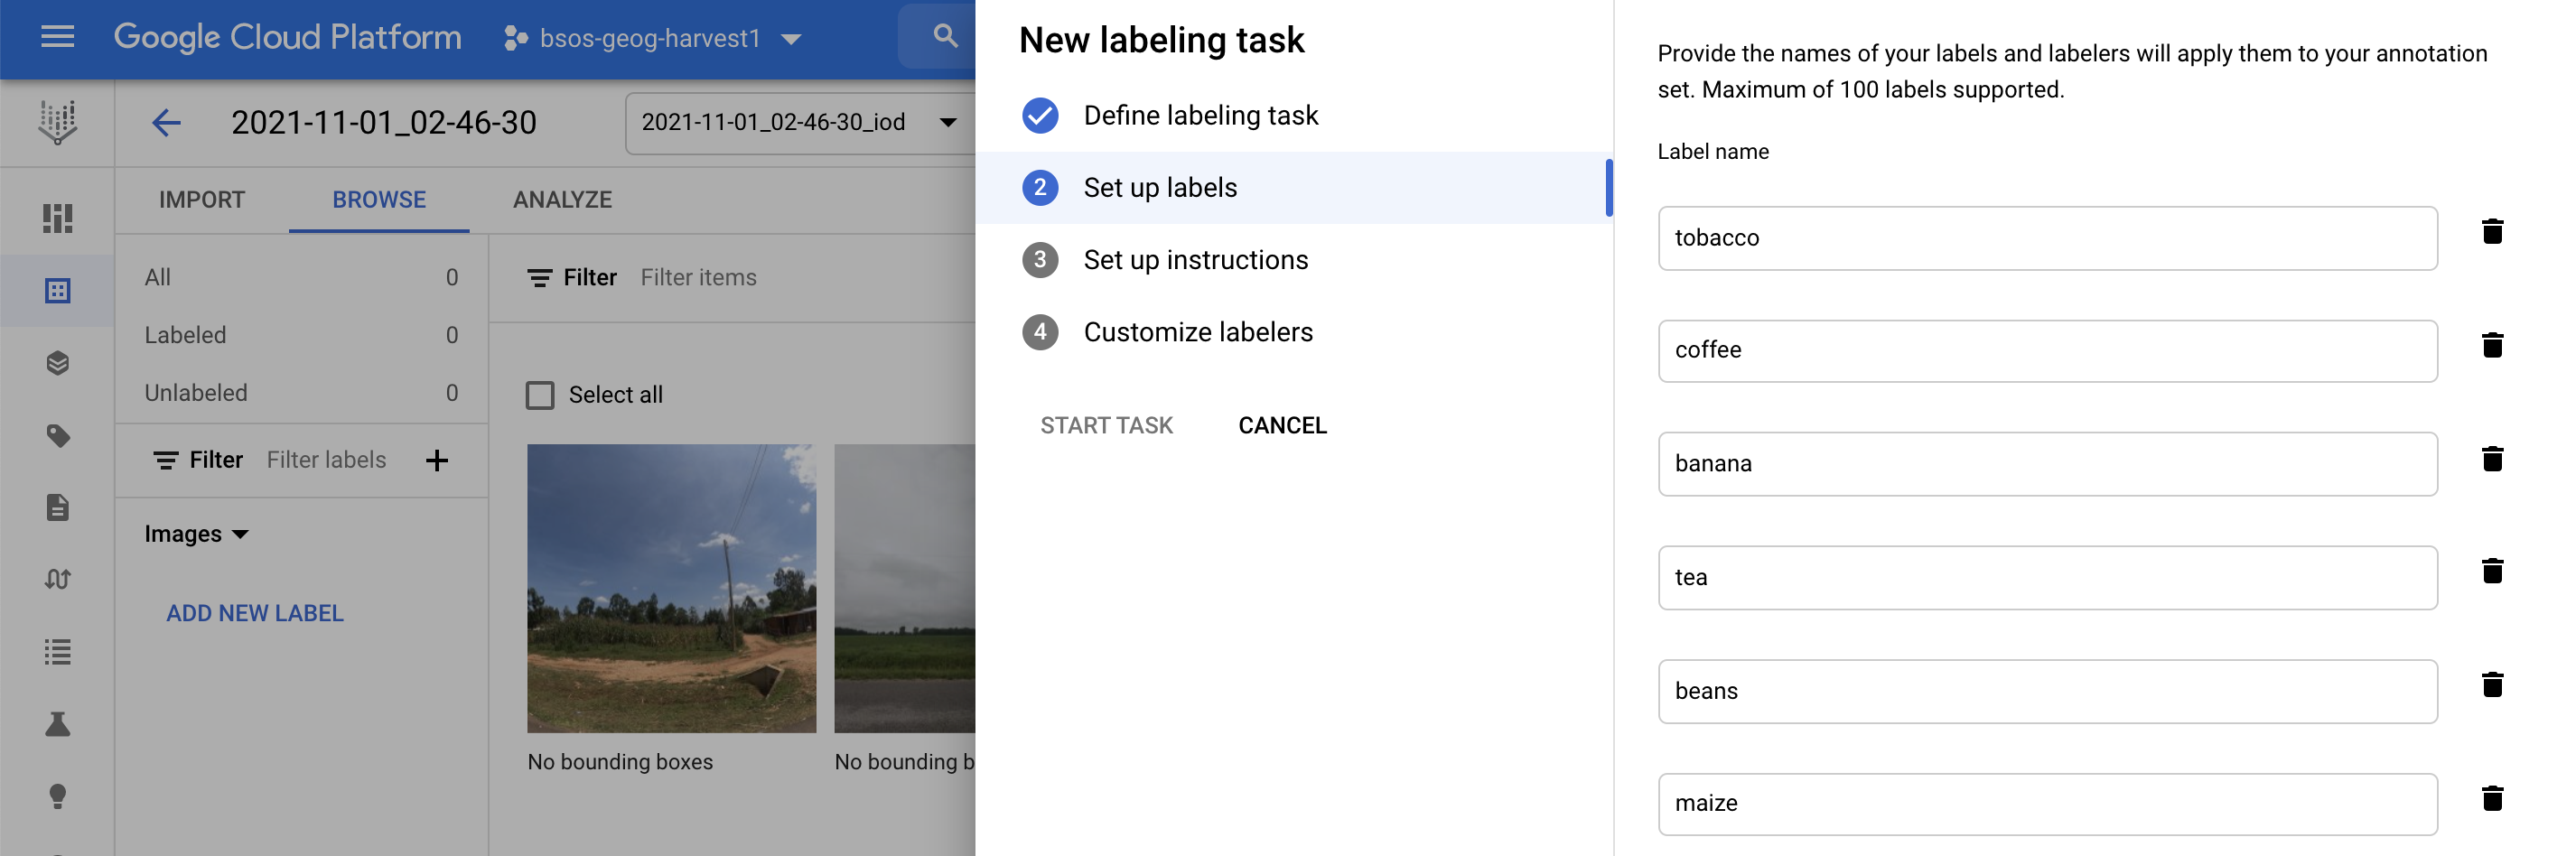

d. In step 3: select the instruction PDF available in `gs://street2sat-gcloud-labeling`. (This can be updated if necessary)

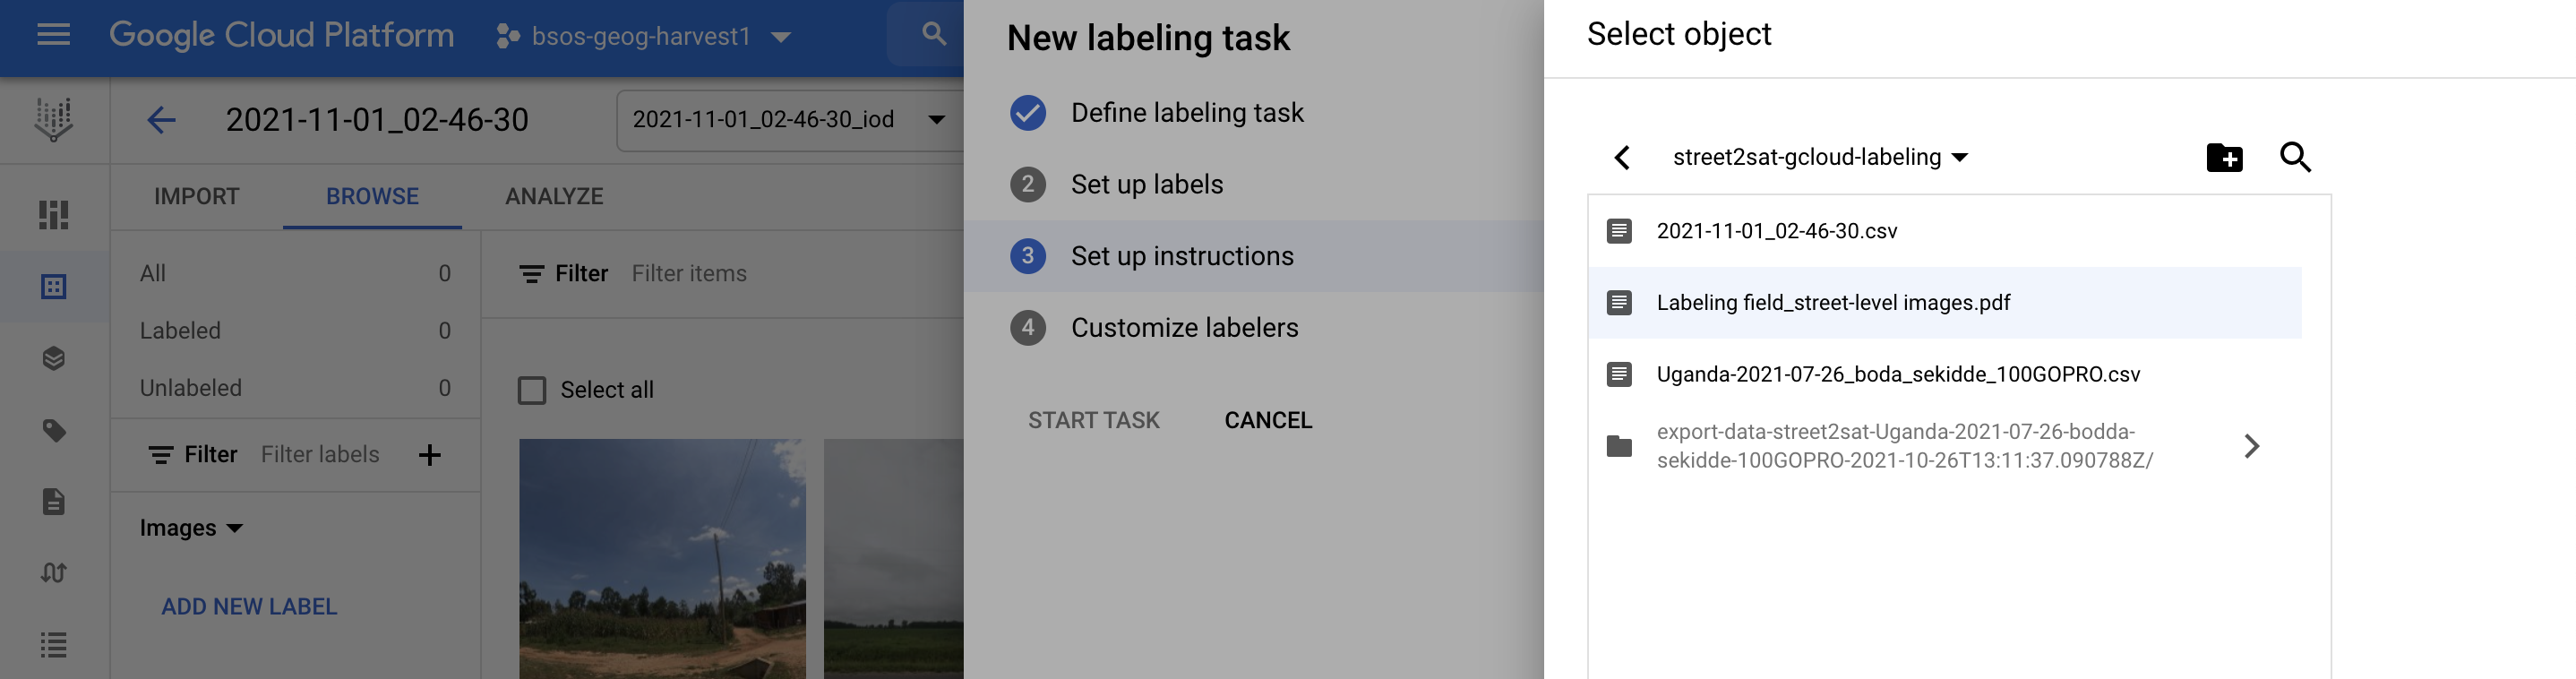

e. In step 4: select the "Street2sat Labelers" group and add your email as a manager.

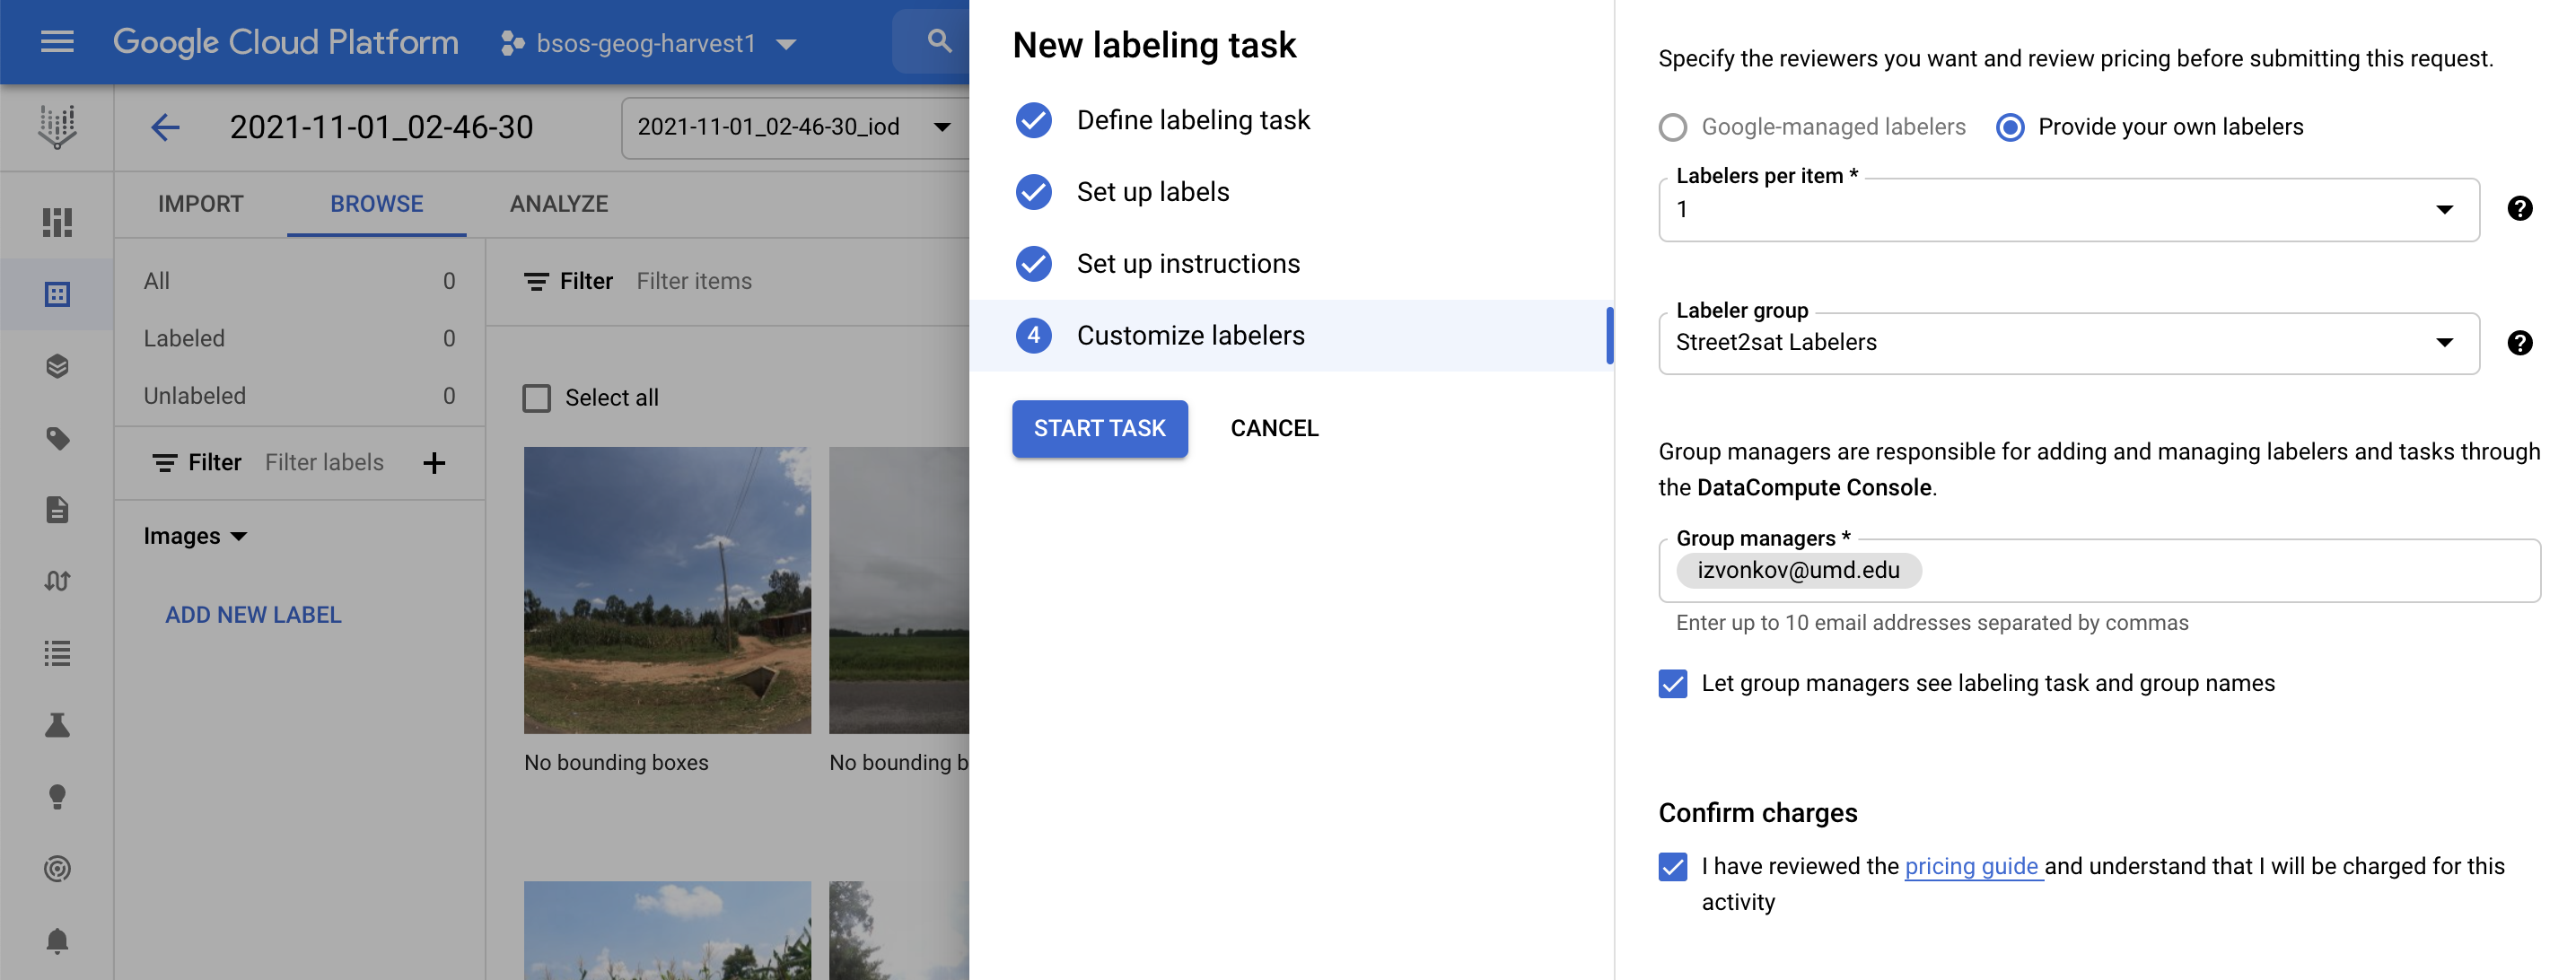

f. After some time (maybe 15 minutes) you should receive an email from noreply-vertexai@google.com that looks like this:
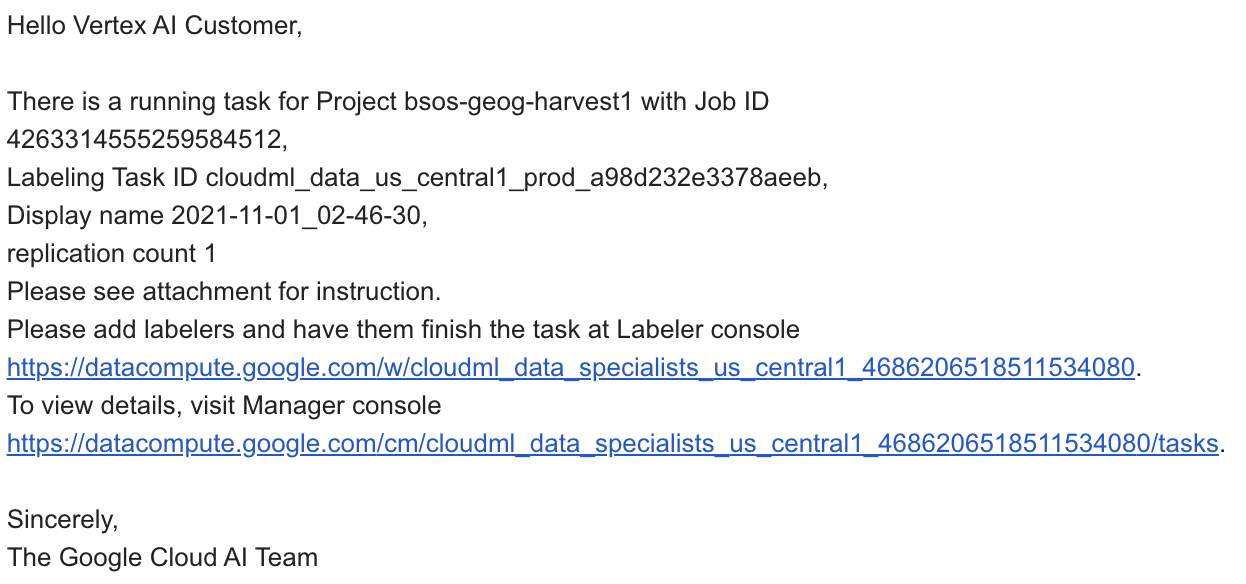


## 4. Labeling Manager Console
Using the second link the above email you can access the Manager console. 
- Tasks - shows the progress of the created Labeling task
- Specialists - shows the list of available labelers (more can be added here)
- Assignments - allows managing who is working on which task

Tasks and Specialists are pretty intuitive, but to change Assignment you must:
1. Populate the Specialists column with an existing specialist (labeler)
2. Populate the Tasks column with a created task
3. Make changes by checking or unchecking specialists
4. Commit changes using the button on the top right

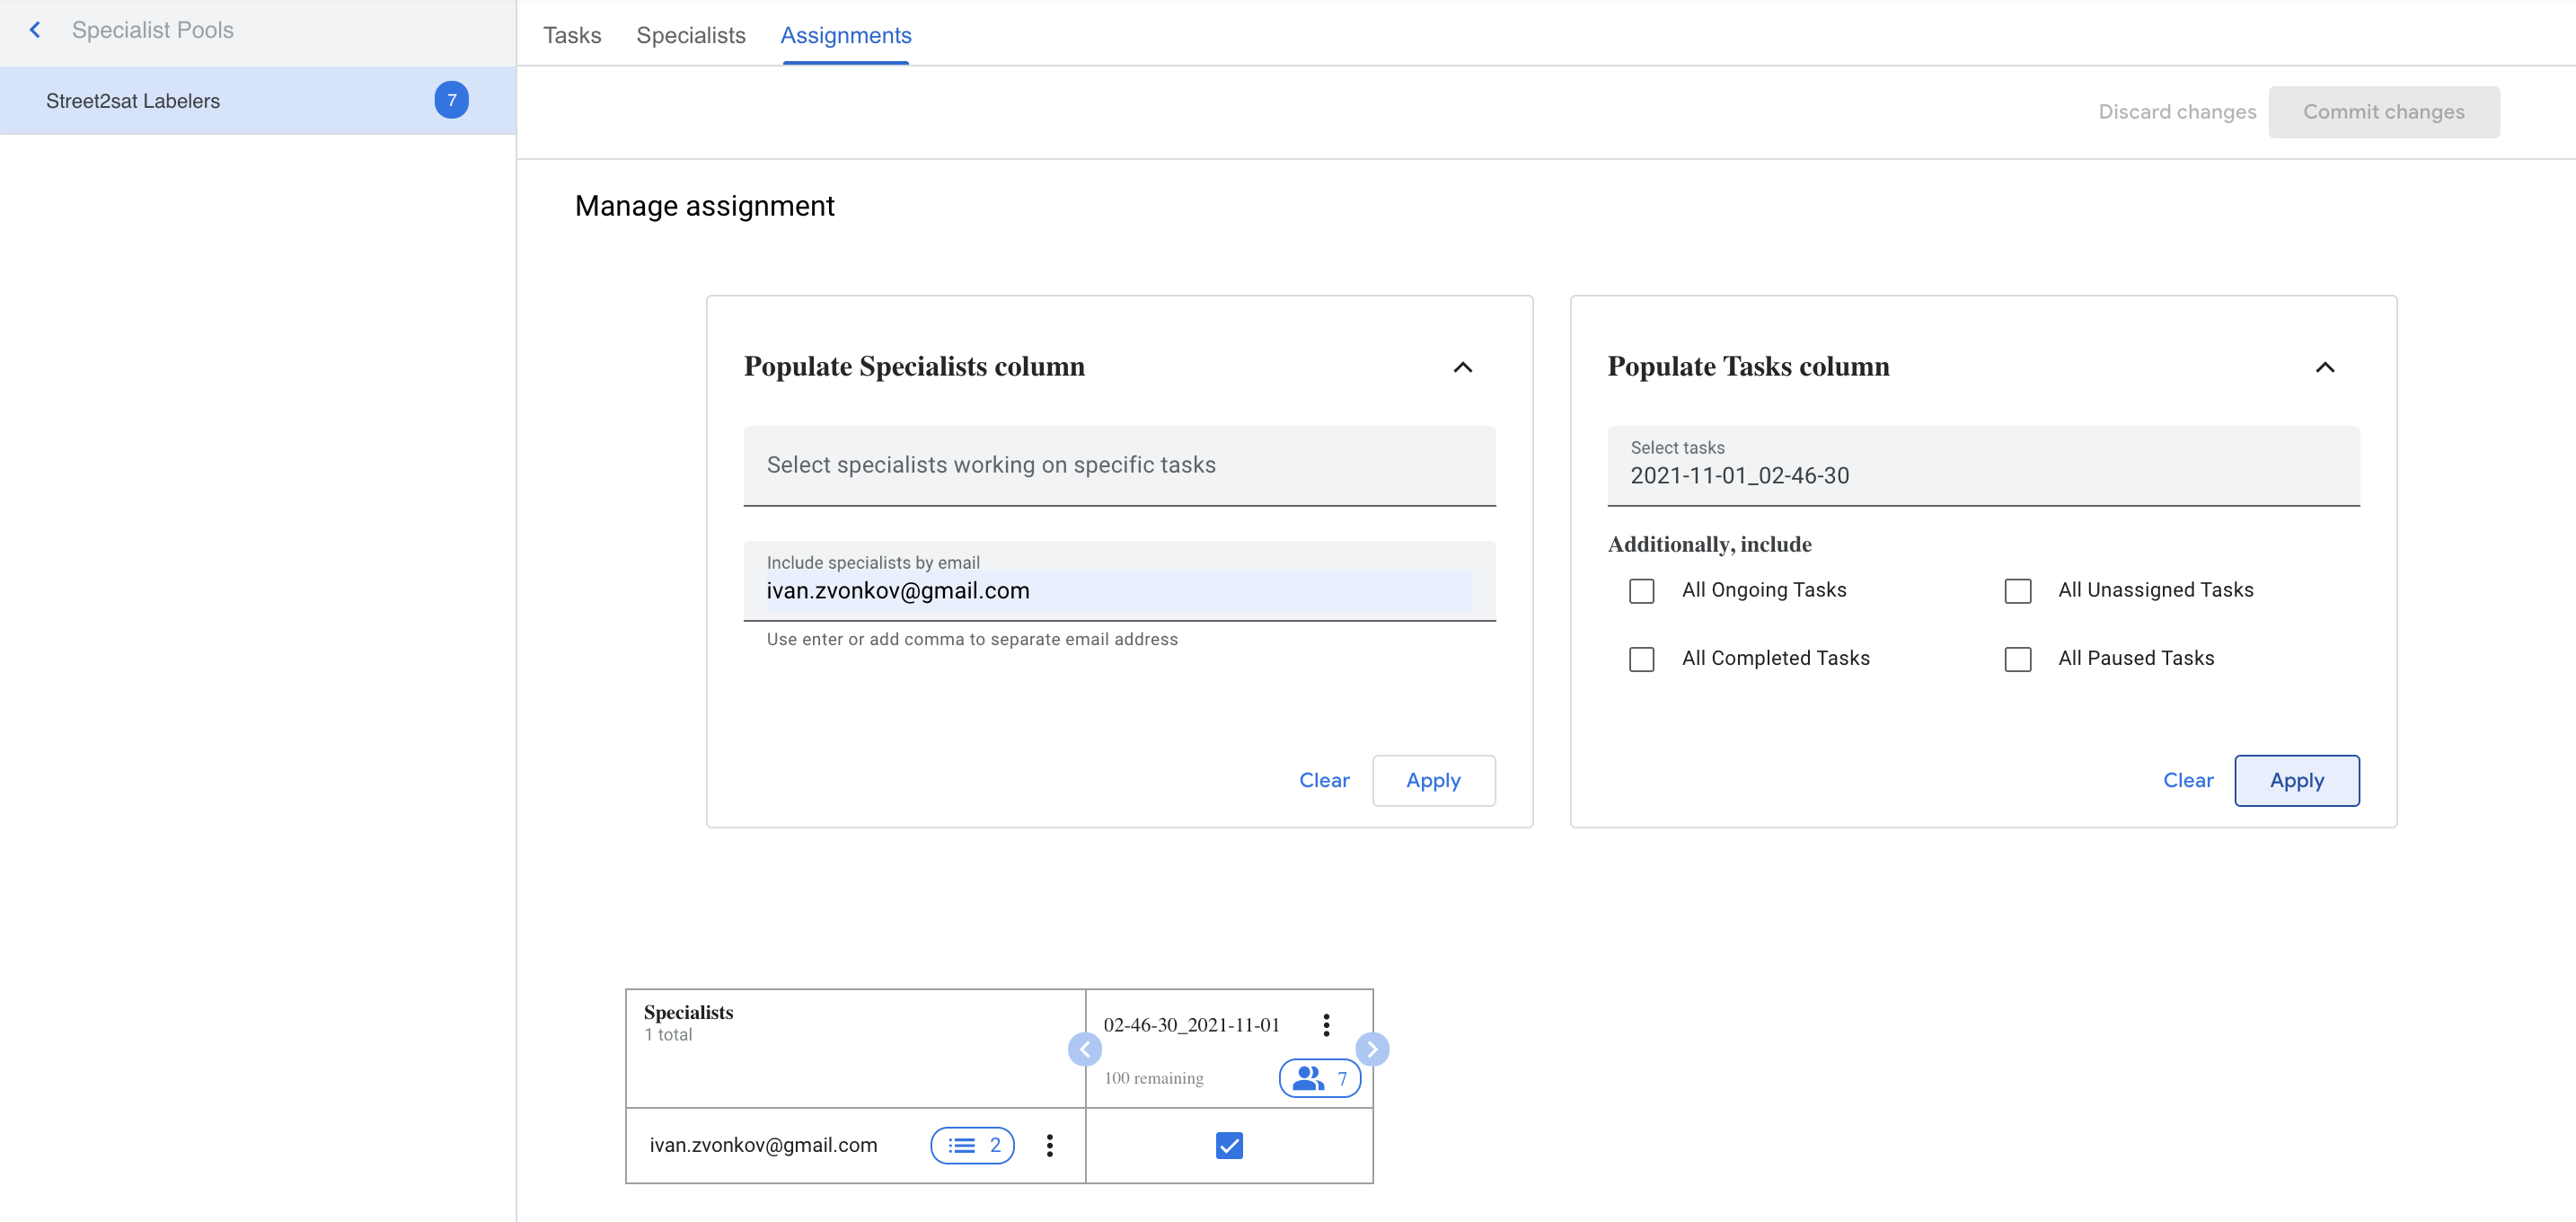


# 5. Actual labeling
Members of the Street2sat labelers group should receive an email like this upon assignment:
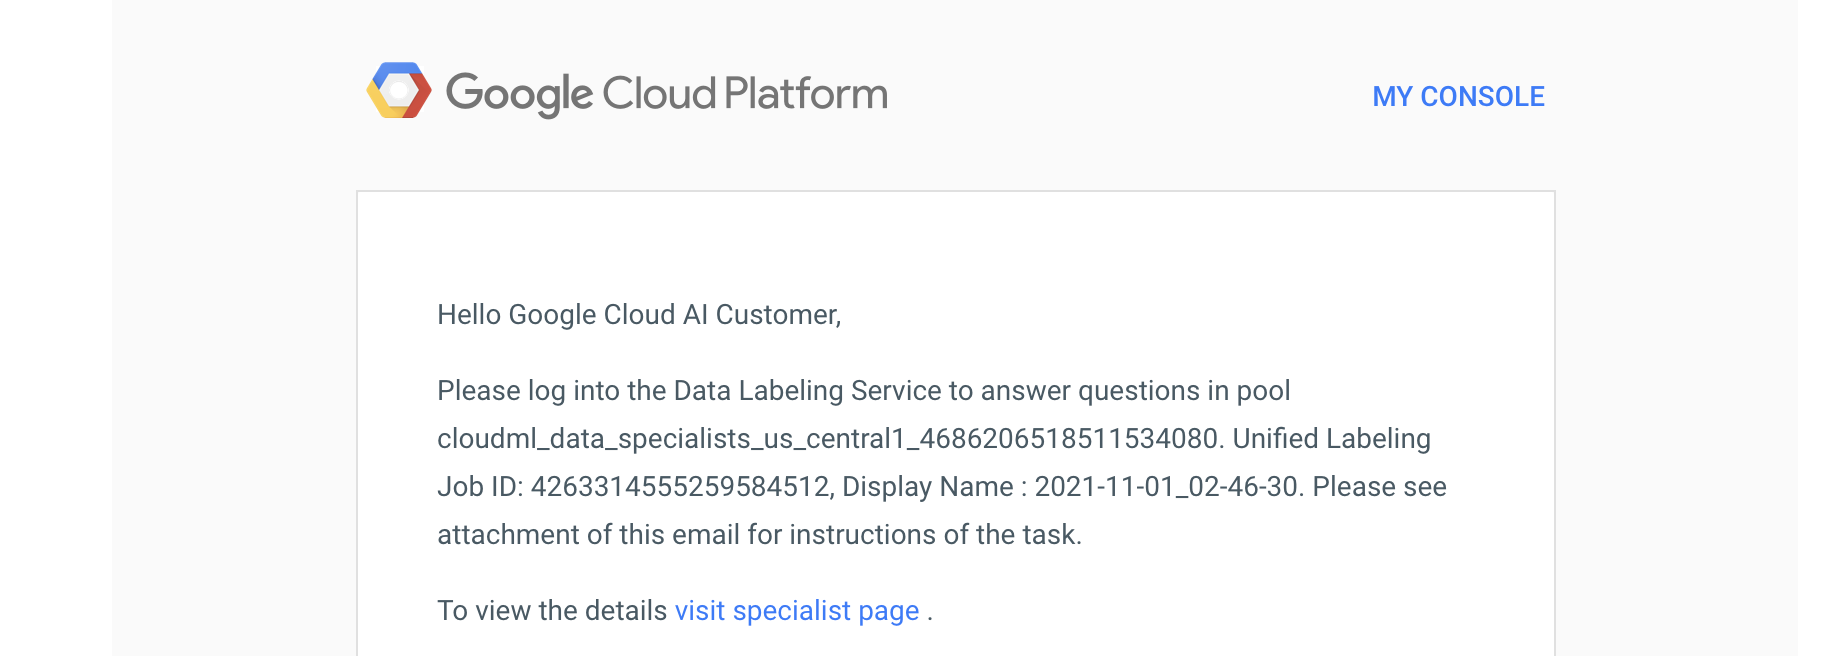

However these emails have not been consistent so a direct link from Step 3f email may need to be manually sent.

Once the specialist clicks the link, they'll see the following page and will be ready to go:
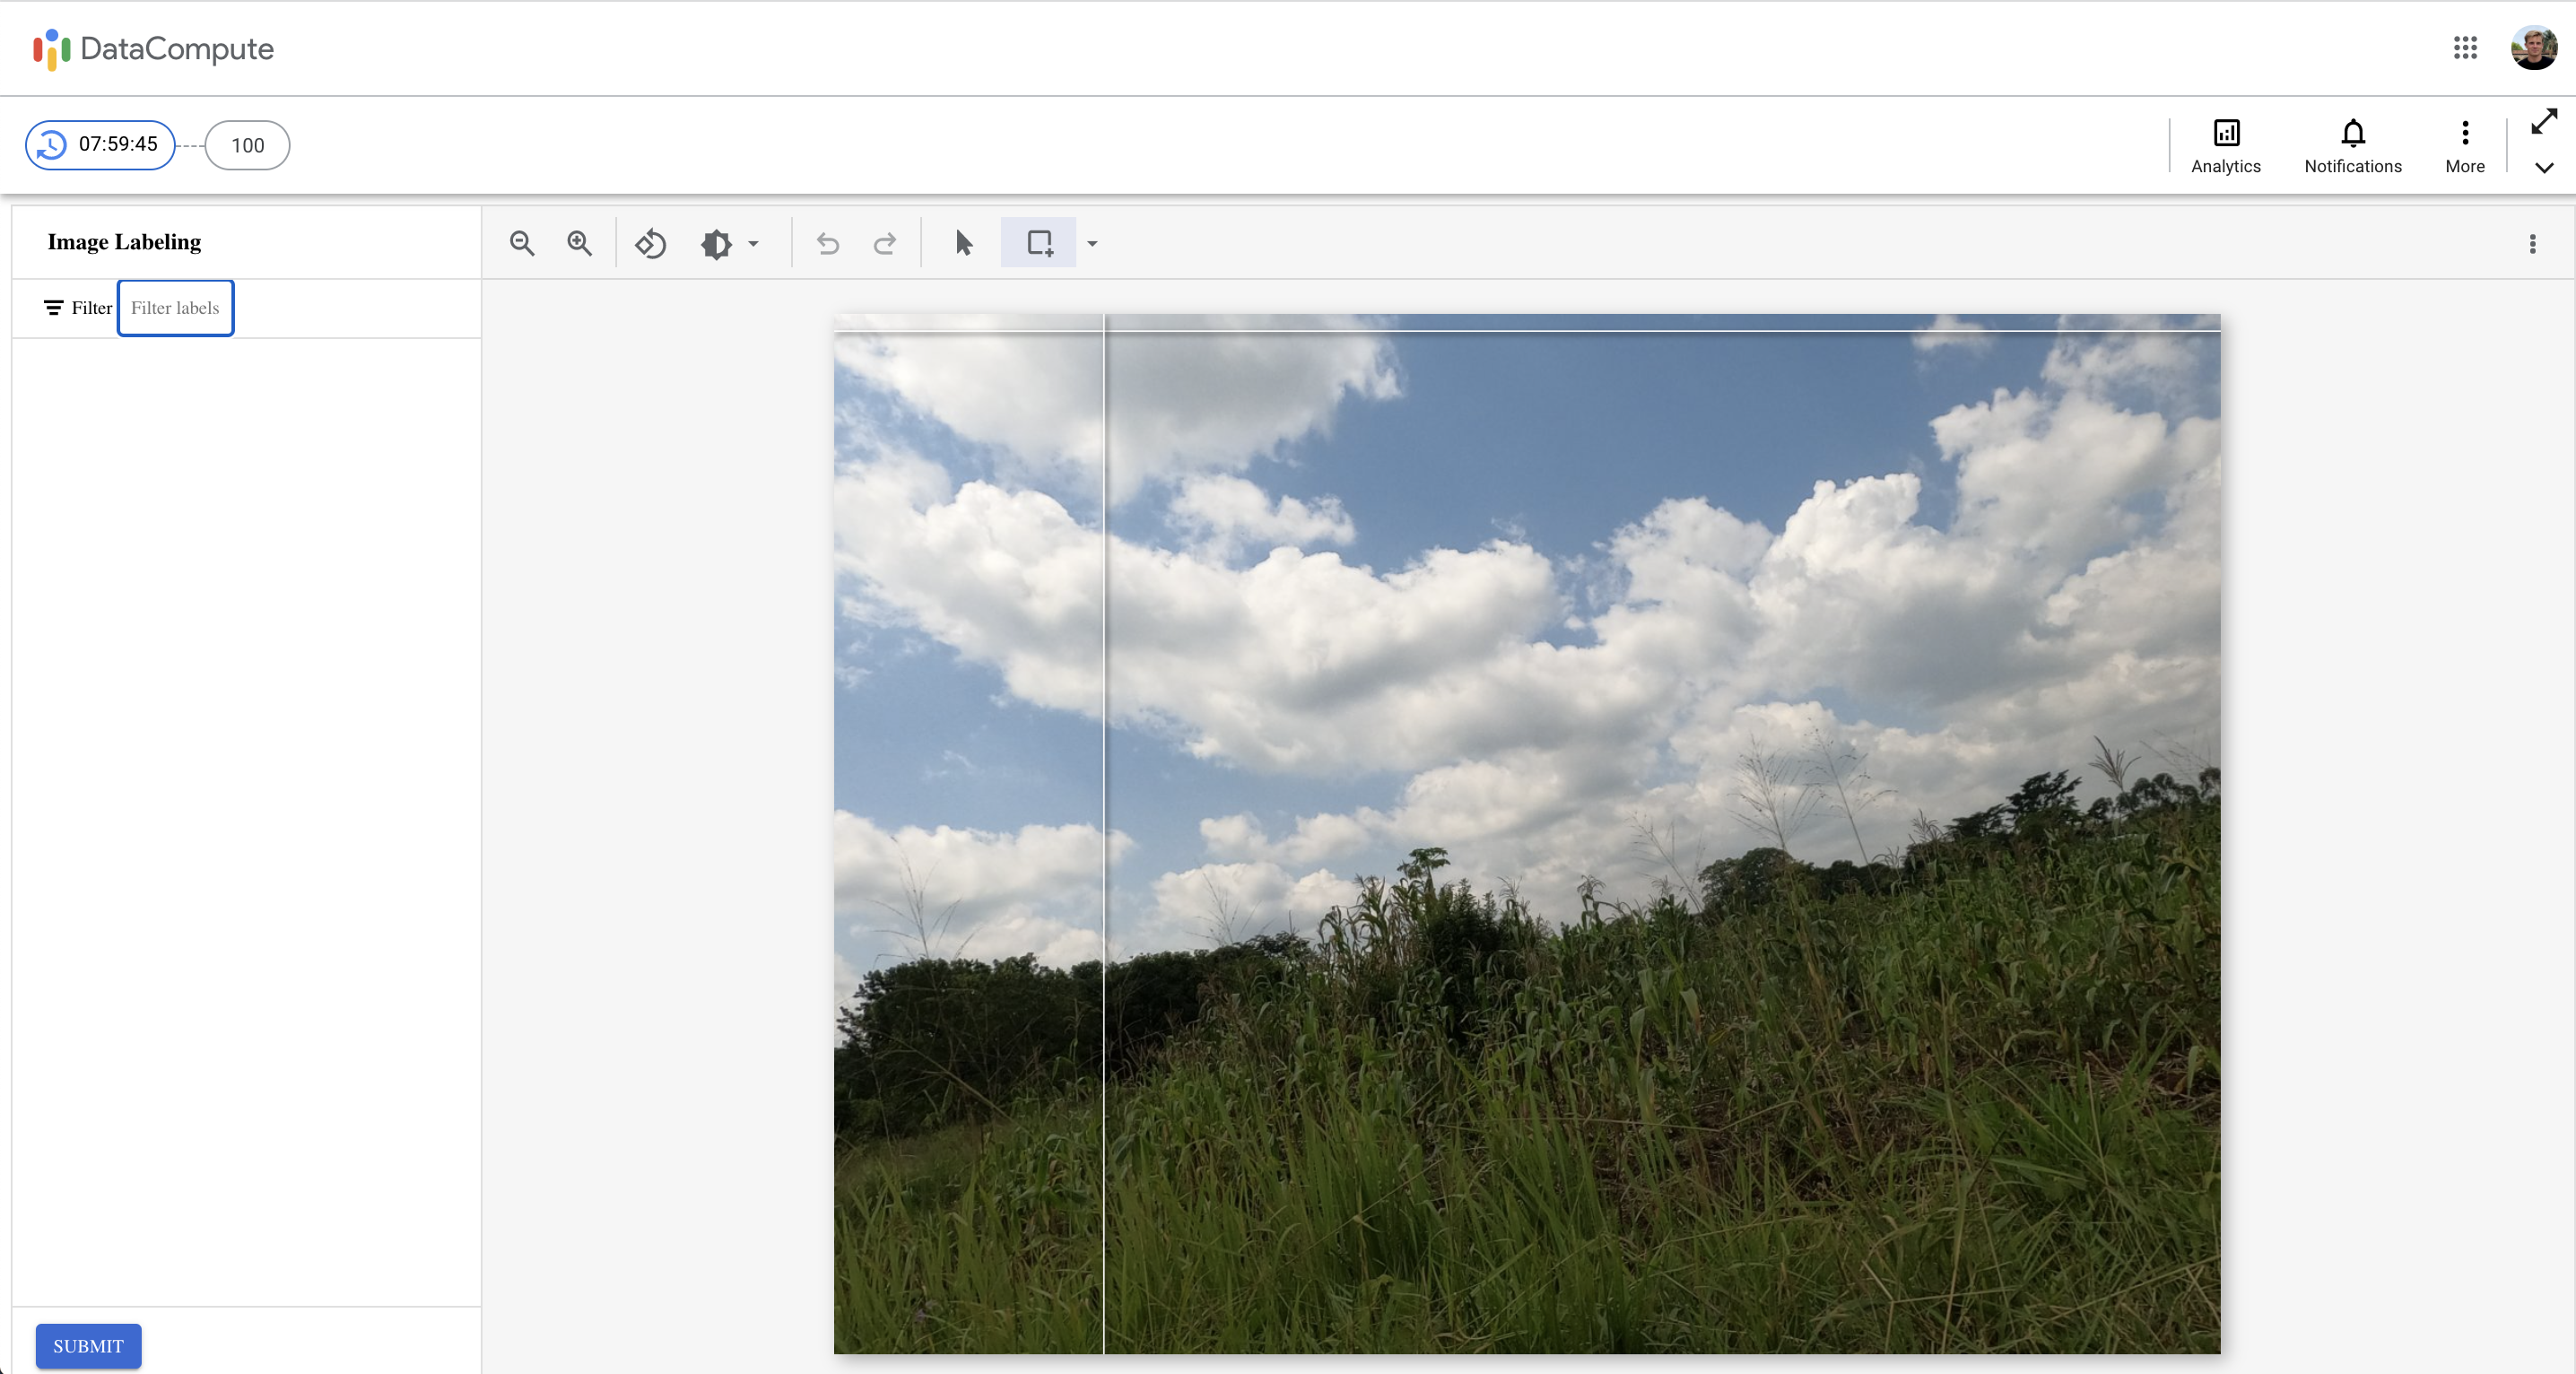

- Since this guide is for individuals creating labeling tasks, I'll leave details about actual labeling on Google Cloud to another slide/document.

## 6. Exporting the labels
To export labels navigate to Vertex AI datasets, click the 3 dots on the desirable dataset and select Export dataset
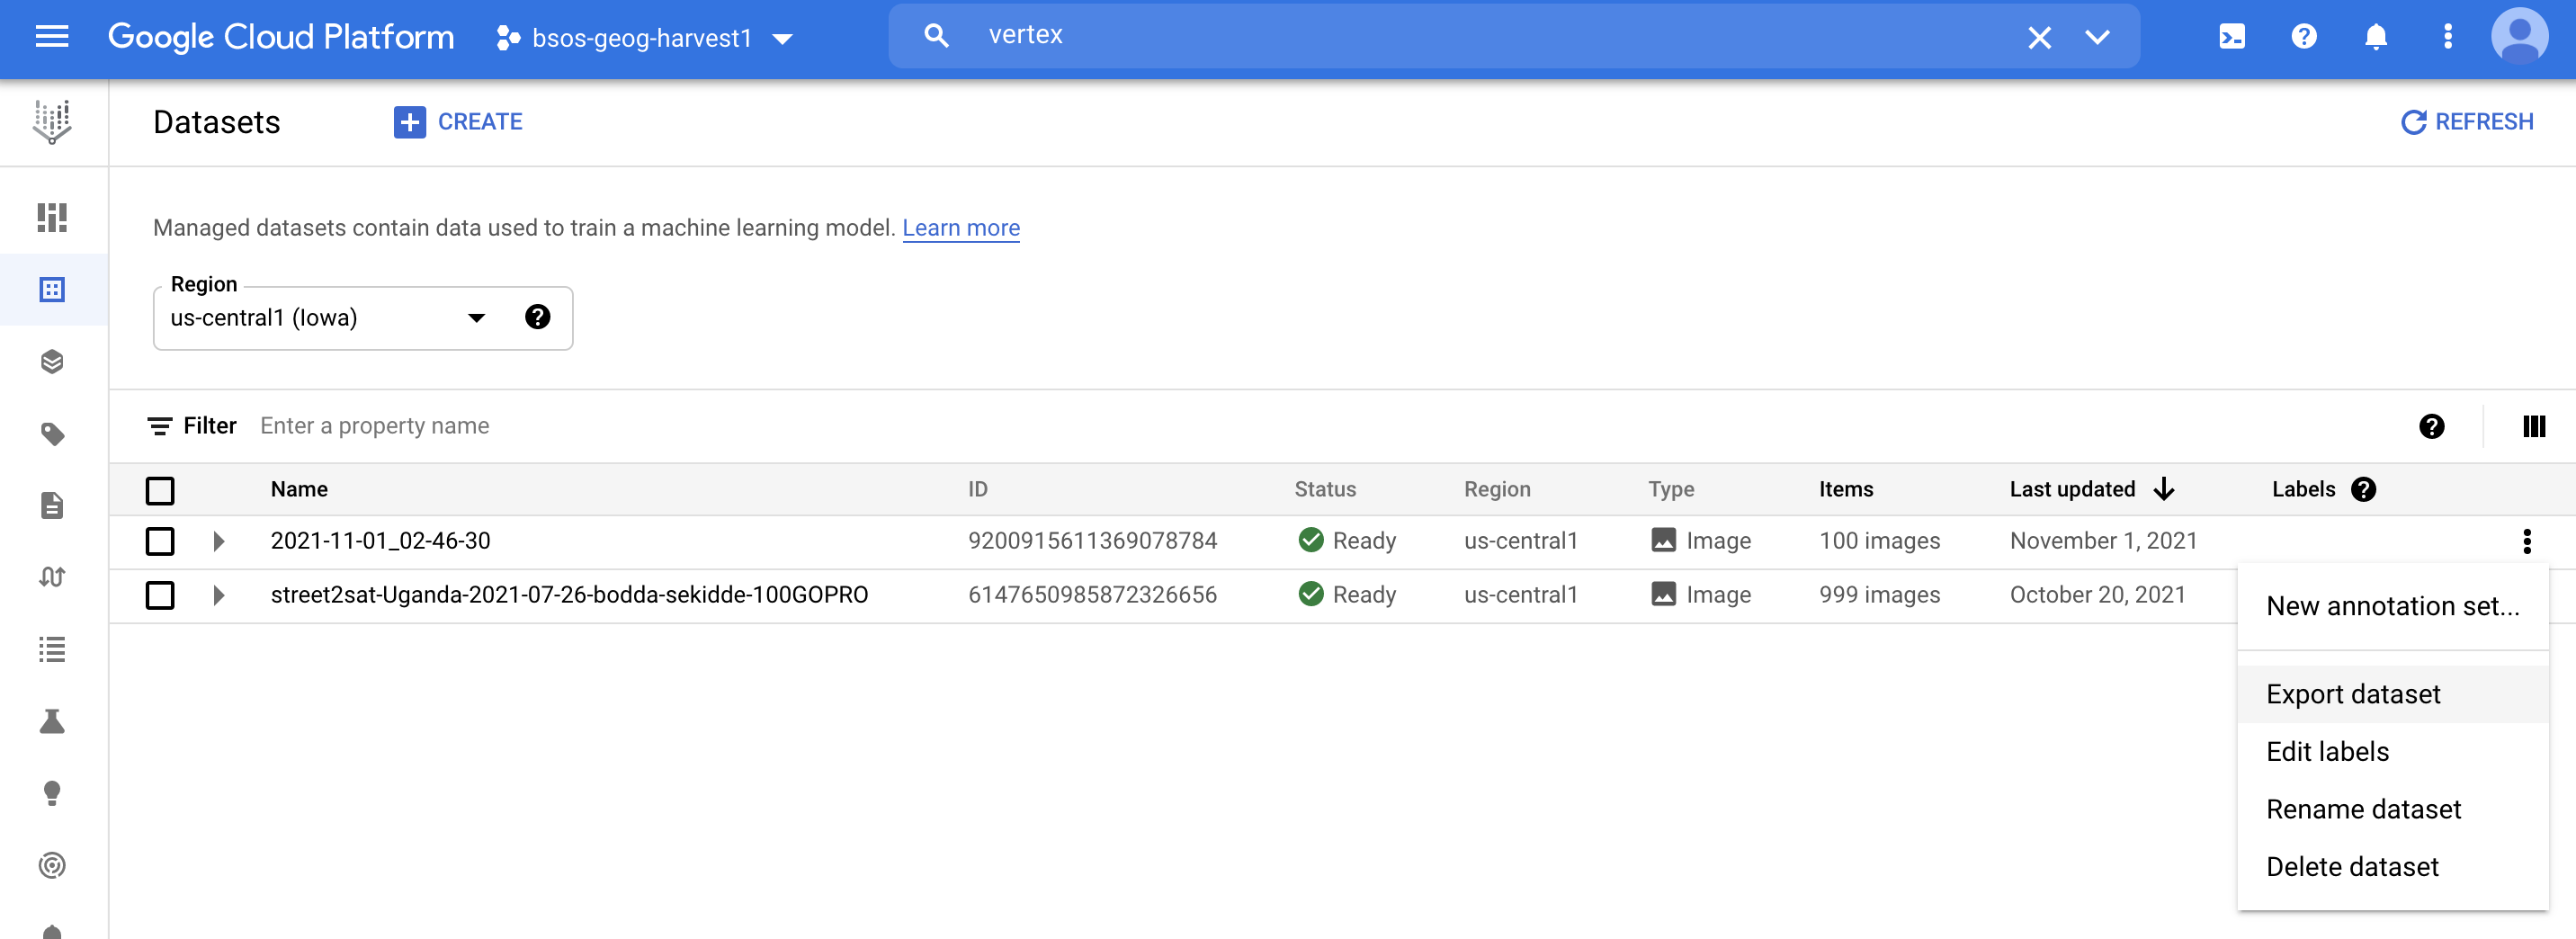

Save the output file directly to the `street2sat-gcloud-labeling` bucket.